## **Load *Monod*+meK-Means and Packages**

In [52]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/')

In [53]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference
from monod.analysis import *

In [54]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import scipy.stats

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

import os

import sklearn
import scanpy as sc
import anndata

import random
import glob

In [55]:
#Packages for Leiden comparison
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

import igraph as ig
import leidenalg as la

import itertools

In [56]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## **Read in data and metadata**

In [121]:
#read in adata with metadata

meta_path = "/home/tchari/metadata/"
adata = anndata.read_h5ad(meta_path+'gehring_multiplex.h5ad')

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/X' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_io/h5ad.py:282: OldFormatWarning: '/obs' was written with a very old version of AnnData. Consider rewriting it.
  OldFormatWarning,
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/obsm' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/uns' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/uns/LouvainRes1.5_categories' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/h

In [122]:
#Set up filepaths for Monod

remain = [[str(i)] for i in range(96) if i not in [93,83]] #Filter out 0 count conditions
all_conds = remain

loom_filepaths = ['/home/tchari/counts/gehring_nsc/loom/nsc_all.loom']*len(all_conds)

dataset_names = ['nsc_'+'_'.join(n) for n in all_conds] #To save
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = dataset_names
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]


n_datasets = len(loom_filepaths)

len(dataset_names):  94



In [123]:
len(all_conds)

94

## **Process Cell Barcodes**

Filter out cell barcodes with low UMI counts

Dataset nsc_0. 
	21232 barcodes in loom, 21063 pass filter. 21232 in annotations; of these, 21232 in loom and 21063 in filtered loom.
	['0']: 21 cells in annotations. 21 in loom. 21 pass filter.
	['1']: 73 cells in annotations. 73 in loom. 73 pass filter.
	['2']: 63 cells in annotations. 63 in loom. 63 pass filter.
	['3']: 114 cells in annotations. 114 in loom. 114 pass filter.
	['4']: 104 cells in annotations. 104 in loom. 104 pass filter.
	['5']: 23 cells in annotations. 23 in loom. 23 pass filter.
	['6']: 130 cells in annotations. 130 in loom. 129 pass filter.
	['7']: 76 cells in annotations. 76 in loom. 74 pass filter.
	['8']: 975 cells in annotations. 975 in loom. 972 pass filter.
	['9']: 17 cells in annotations. 17 in loom. 14 pass filter.
	['10']: 6 cells in annotations. 6 in loom. 6 pass filter.
	['11']: 130 cells in annotations. 130 in loom. 130 pass filter.
	['12']: 71 cells in annotations. 71 in loom. 71 pass filter.
	['13']: 68 cells in annotations. 68 in loom. 68 pass filt

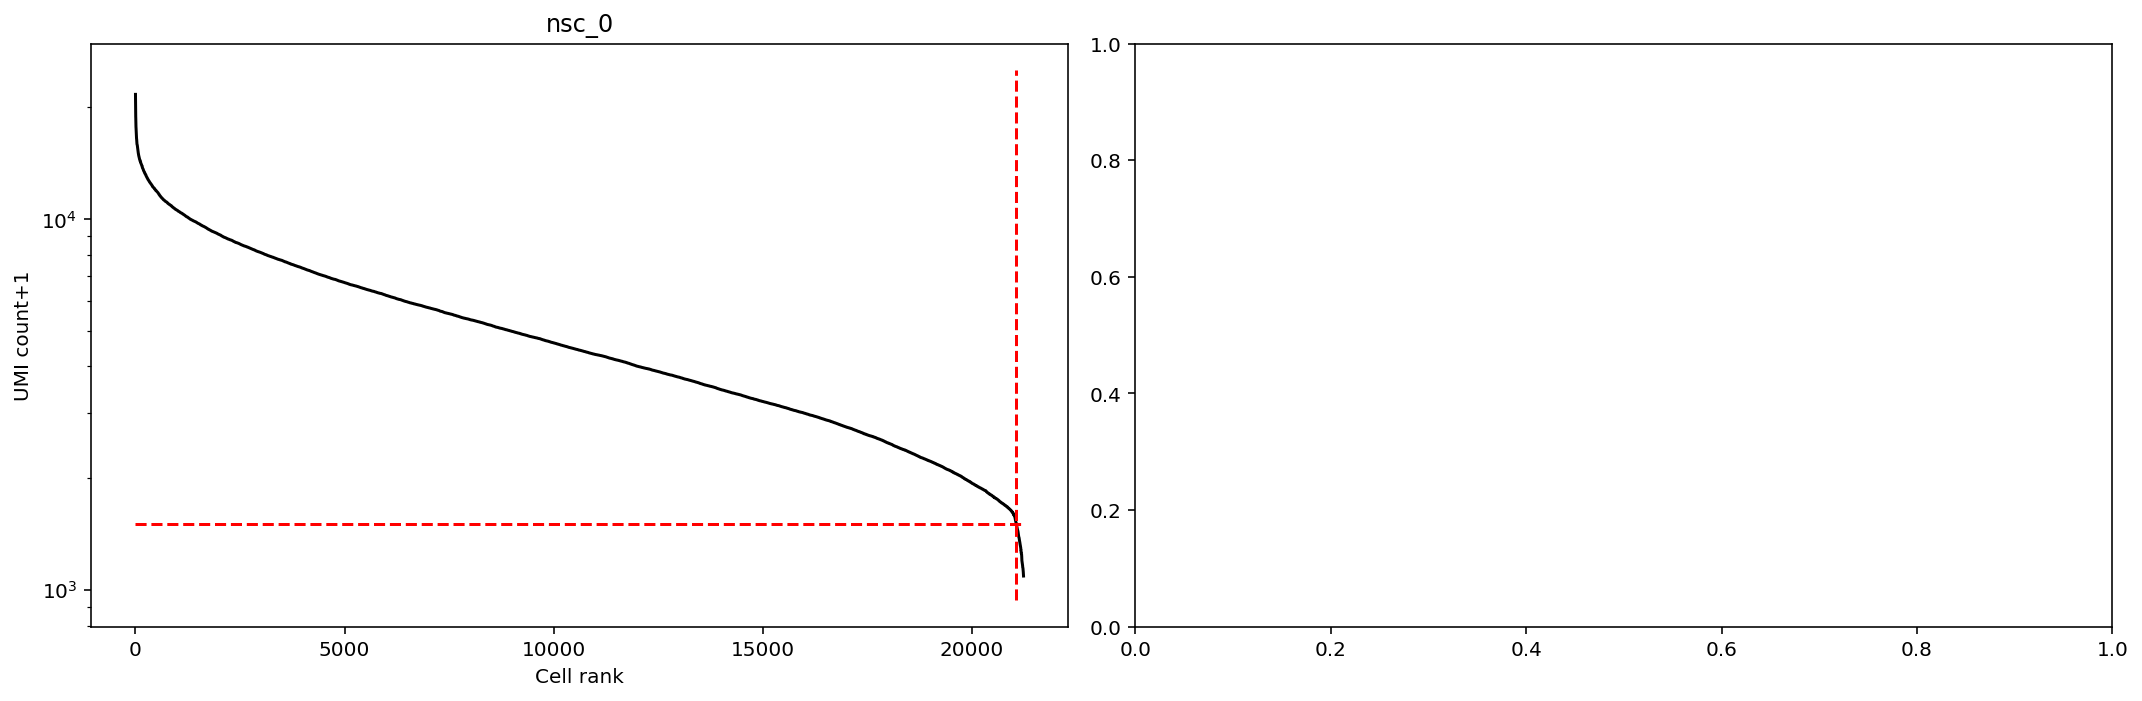

In [124]:
cf = []
thr_lb = [1.5e3]*2

fig1,ax1 = plt.subplots(1,2,figsize=(15,5))

for k in range(1):
    filename = loom_filepaths[k]
    dataset_name = raw_data_locations[k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = len(adata.obs_names)
        annot_bcs_in_loom = adata.obs_names.isin(bcs).sum()
        annot_bcs_in_filt_loom = adata.obs_names.isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #if k==0:
        for subcluster in all_conds:
            annot_bcs = adata[(adata.obs['assignments'].isin(subcluster))].obs_names
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_all_gehring.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

## **Test meK-Means on Conditions**

Are there novel perturbed populations of cells within conditions?

In [125]:
#Get full count matrices and barcodes
ds = lp.connect('/home/tchari/counts/gehring_nsc/loom/nsc_all.loom')
U = ds.layers['unspliced'][:].T
S = ds.layers['spliced'][:].T
bars = ds.ca['barcode']
g_names = ds.ra['gene_name']
ds.close()

In [126]:
lit_genes=['Srsf3', 'Ptbp', 'Nova', 'Rbfox', 'Elavl', 'Celf', 'Dbhs', 'Msi', 'Pcbp', 'Mbnl', 
           'Ptbp1', 'Khdrbs3', 'Khdrbs1',
          'Elavl2', 'Elavl3', 'Elavl4', 'Celf4', 'Msi1', 'Msi2', 'Mbnl1',
          'Oct3', 'Oct4', 'Cdc42', 'Hes5', 'Pax6', 'Gap43', 'Tubb3', 'Map2', 'Tuj1', 'Pou5f1', 'Nes',
          'Id1', 'Id2', 'Tcf3','Hes5','Id2','Id4','Hes1','Notch1','Sox9','Kif2c', 'Vim',
          'Nusap1', 'Top2a', 'Cdca8', 'Mki67','Cux1','Cux2','Emx2','Ascl1','Egfr','Dlx2',
          'Olig1', 'Olig2', 'Sox9', 'Gfap','Slc1a2', 'Glul','Pdgfa','Sox10','Prc1', 'Cenpf', 'Ube2c', 'Cdc20',
          'Dnmt3b', 'Dnmt3l', 'Tet1','Tet2','Hdac2', 'Hdac7','Hdac8',
          'Sox1', 'Tgfb2', 'Ntf3', 'Pax6', 'Id2', 'Fgf18', 'Nanog',
          'Mapk','Jnk', 'p38','Mapk8','Mapk14',
          'Hdac10','Hdac4','Dnmt1','Hdac2','Hdac8','Jmjd1c','Dnmt3l','Dnmt3b','Tet2','Tet1',
           'Jmjd6','Jmjd7','Hdac1','Hdac6','Hdac3','Tet3','Hdac5','Dnmt3a','Hdac7','Hdac9','Smarca2',
           'Jmjd5','Bmi1','Mbd5','Hdac11','Jmjd8','Gadd45a','Jmid4',
          'Pax6','Dcx','Map2','S100b','Cyp26a1','Rara','Rarb','Mary','Rxra','Rxrb','Dio1','Dio2',
           'Dio3','Tra','Tra1','Tra2','Trb','Trb1','Trb2','Nestin','Nes','Sox1','Sox2','Dcx','Tuj1',
           'Neun','Rbfox3','Syp','Chat','Sert','Olig2']


In [63]:
#Splicing NSC dev: https://elifesciences.org/reviewed-preprints/87083
#Splicing factors:  SRSF3, Ptbp, Nova, Rbfox, Elavl, Celf, Dbhs, Msi, Pcbp, Mbnl, Ptbp1, Khdrbs3, Khdrbs1
#Elavl2, Elavl3, Elavl4, Celf4, Msi1, Msi2, Mbnl1

#RA genes (to differentiation) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3837441/
#Oct3, Oct4, Cdc42 , Hes5, Pax6, Gap43, Tubb3, Map2,Tuj1, Pou5f1, Nes 

#More RA genes https://www.nature.com/articles/2403699
#Id1, Id2, Tcf3

#https://www.sciencedirect.com/science/article/pii/S2211124717318132?via%3Dihub
#Hes5,Id2,Id4,Hes1,Notch1,Sox9,Kif2c, Vim

#Proliferation:
#Nusap1, Top2a, Cdca8, Mki67 


#Switch to Diff --> Cux1,Cux2,Emx2


#Activated --> Ascl1,Egfr,Dlx2, 

#Astro diff: Olig1, Olig2, Sox9, Gfap,
#Astro: Slc1a2, Glul
#Oligo Diff: Pdgfa, Sox10

#Mitosis:Prc1, Cenpf, Ube2c, Cdc20



#RA Response:https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0132566 (mESCs)
#Dnmt3b, Dnmt3l, Tet1, and Tet2 ,Hdac2, Hdac7, and Hdac8 
#Sox1', 'Tgfb2', 'Ntf3', 'Pax6', 'Id2', 'Fgf18', 'Nanog'
#
#'Hdac10','Hdac4','Dnmt1','Hdac2','Hdac8','Jmjd1c','Dnmt3l','Dnmt3b','Tet2','Tet1','Jmjd6','Jmjd7','Hdac1','Hdac6','Hdac3','Tet3','Hdac5','Dnmt3a','Hdac7','Hdac9','Smarca2','Jmjd5','Bmi1','Mbd5','Hdac11','Jmjd8','Gadd45a','Jmid4'



#RA on nscs:  https://www.sciencedirect.com/science/article/pii/S0300483X23000471
#'Pax6','Dcx','Map2','S100b','Cyp26a1','Rara','Rarb','Mary','Rxra','Rxrb','Dio1','Dio2','Dio3','Tra','Tra1','Tra2','Trb','Trb1','Trb2','Nestin','Nes','Sox1','Sox2','Dcx','Tuj1','Neun','Rbfox3','Syp','Chat','Sert','Olig2'



**Run meK-Means**

In [127]:
#Threshold for filtering genes based on expression patterns
def nb_thresh(U,S,var_t = 1.5,u_min =0.02,s_min =0.02):
    '''
    Take in U,S matrices, and find genes that meet var/mean thresh
    U,S are cellxgene
    '''
    var_threshold = var_t
    U_mean = U.mean(0)
    S_mean = S.mean(0)
    U_var = U.var(0)
    S_var = S.var(0)

    #if l == '/home/tchari/counts/allen_bivi/loom/processed_allen_B02H01A02_raw.loom':
    u_min = u_min
    s_min =  s_min


    fitted_idx = (U_mean > u_min) & (S_mean > s_min) \
    & (((U_var-U_mean)/(U_mean**2)) > var_threshold)\
    & (((S_var-S_mean)/(S_mean**2)) > var_threshold)\
    & (np.abs(np.log(S_mean/U_mean)) < 4) 
    #((U_mean/S_mean) > 1.0) #labeled mRNA (new synth) is mainly intronic counts
    
    #(np.abs(np.log(S_mean/U_mean)) < 4) 
    
    
    return fitted_idx

In [128]:
def check_at_bounds(phys_params,thr=0.01,phys_lb=[-2.0, -1.8, -1.8 ],phys_ub=[4.2, 2.5, 2.5]):
    #Check for genes where parameter fits are close to boundary of grid
    x = np.any(np.logical_or(
        np.array(phys_lb)+thr > phys_params,
        np.array(phys_ub)-thr < phys_params) ,1)
    return x

In [129]:
def get_assigns(sr):
    '''
    Get cell cluster assignments
    '''
    cats = np.array([None]*len(sr[0].filt))
    for r in sr:
        cats[r.filt] = r.assigns
    return cats

In [130]:
def print_summary(sr):
    '''
    Get summary of clustering results
    '''
    print('--------------------------')
    print('Model AIC Score: ',sr[0].aic[0])
    for r in sr:
        print('Clus '+str(r.assigns)+' with '+str(np.sum(r.filt))+' cells')
    print('--------------------------')

In [131]:
def vis_metrics(results,title,ks,figsize=(18, 5),s=50,fname=None):
    '''
    Visualize -Q function and KLD over epochs, and -AIC for final model inference

    results: list of len num_ks, of lists of SearchResults objs per K tested (e.g. [[SearchResults],[SearchResults,SearchResults]] for K=1&2)
    title: title string for leftmost, plot
    ks: list of ks tested (e.g. [1,2])
    figsize: tuple for size of figure
    s: size of dots in scatterplot
    save_file: string, output file to save image

  '''

    num_ks = len(results)
    sets = []
    qs = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()

    aic = []
    fin_k = []
    kls = []

    epoch = len(results[0][0].all_qs.flatten())
    epos = list(range(1,epoch+1))*num_ks

    for i in range(num_ks):

        qs += list(-1*results[i][0].all_qs.flatten())
        sets += [ks[i]]*epoch
        aic += [results[i][0].aic[0]]
        fin_k += [len(results[i])]


        concat_klds = []
        ks_used = []
        for r in results[i]:
            concat_klds += [r.all_klds[0,:,:]]
            ks_used += [r.assigns]

        concat_klds = np.array(concat_klds)
        concat_klds = concat_klds.reshape((concat_klds.shape[1], concat_klds.shape[2],concat_klds.shape[0]))

        kls += list(np.mean(np.sum(concat_klds[:,:,:],axis=1),axis=1)) #Sum of klds across k clusters


    res['Q'] = qs
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]

    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k

    #Plot Q function over epochs
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)

    sns.lineplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    g1=sns.scatterplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('-Q')
    ax[0].legend(
          title='Set K')
    ax[0].set_title(title)
    sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))


    #Plot klds over epochs
    g2=sns.lineplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')
    ax[1].legend(
          title='Set K')
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))



    #Plot aics
    g3=sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final Assigned k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='Set K')
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)


In [132]:
#Set up files for meK-Means runs and different Ks
conds_forinf = [45,46,47] #21,22,23     18,19,20,  42,43,44,
Ks = [3,5]
cfs = [cf[i] for i in conds_forinf]


loom_filepaths = ['/home/tchari/counts/gehring_nsc/loom/nsc_all.loom']*len(Ks)

#sub_dataset_names = ['meK_gehr_'+str(i)+'_k'+str(j) for i,j in zip(conds_forinf,sub_ks)]



In [133]:
epochs = 10

In [134]:
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-7.888888888888889, -0.6999999999999997] 
samp_ub = [-7.888888888888889, -0.6999999999999997]
gridsize = [1,1]


In [138]:
# !rm -r ./fits/gg_240409_029_meK_gehring_1

In [136]:
#Get barcodes of all populations we're clustering
sub_cfs = cf[conds_forinf[0]]
for x in conds_forinf[1:]:
    sub_cfs = (sub_cfs | cf[x])

In [139]:
result_strings = []
data_names = []

S_sub = S[sub_cfs,:]
U_sub = U[sub_cfs,:]

#Make anndata with conditions and get most variable genes
adata = anndata.AnnData(X=S_sub)
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
g_filt_hvg = adata.var.highly_variable

#Filter for overdispersed *and* enough U/S counts for clustering
g_filt = nb_thresh(U_sub,S_sub,var_t = 1.5,u_min =0.01,s_min =0.01) #u_min =0.01,s_min =0.01
g_filt_lit = pd.Categorical(g_names).isin(lit_genes)


final_filt =  (g_filt_hvg & g_filt) #| (g_filt_lit  & g_filt) #Filter hvgs + add lit genes
final_names = g_names[final_filt]

print(str(np.sum(final_filt)),' genes')
for c in range(len(conds_forinf)):
    
    print('Cond: ',str(conds_forinf[c]))

    dataset_names = ['meK_gehr_'+str(i)+'_k'+str(j) for i,j in zip([conds_forinf[c]]*len(Ks),Ks)]
    data_names += dataset_names
    
    dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                                 transcriptome_filepath, \
                                                 dataset_names, \
                                                 attribute_names=attribute_names,\
                                                 batch_location='./fits',meta='meK_gehring',batch_id=1,\
                                                 n_genes=len(final_names),\
                                                 exp_filter_threshold=None,cf=[cfs[c]]*len(Ks),
                                                 viz=False,
                                                 genes_to_fit=final_names)
    
    
    for i in range(len(Ks)): #Here only running meK-Means for K=5,10 not K=1

        #Define model with bursty transcription and Poisson molecule capture/sampling
        fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

        #Set up mminference parameters
        inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                    dataset_strings[i],fitmodel,k=Ks[i],epochs=epochs,use_lengths = True,
                    gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

        #Read in loom file with filtered barcodes
        search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, 
                    dataset_names[i],
                    dataset_strings[i], dir_string, viz=False, 
                    dataset_attr_names=attribute_names,
                    cf=cfs[c])

        #Run inference(fit_all_grid_points()) and Save result file strings
        full_result_string = inference_parameters.fit_all_grid_points(30,search_data) 

        result_strings.append(full_result_string)

    

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


68  genes
Cond:  45


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


mstep self.weights:  [0.39835725 0.29681281 0.30482994]
Q Function:  -87698.74441711442



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


mstep self.weights:  [0.43686216 0.28432404 0.2788138 ]
Q Function:  -86675.85263077402



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


mstep self.weights:  [0.26546566 0.34846697 0.38606737]
Q Function:  -89957.38659189947



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.01it/s]


mstep self.weights:  [3.84173557e-04 4.09632003e-01 5.89983823e-01]
Q Function:  -89136.72063839831



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.50it/s]


mstep self.weights:  [2.77389834e-10 3.72123412e-01 6.27876588e-01]
Q Function:  -86981.45782696907



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.42it/s]


mstep self.weights:  [2.77315585e-10 3.60985230e-01 6.39014770e-01]
Q Function:  -86438.84122173938



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.52it/s]


mstep self.weights:  [2.77315585e-10 3.47086627e-01 6.52913372e-01]
Q Function:  -86309.21015857665



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.47it/s]


mstep self.weights:  [2.77315585e-10 3.38705564e-01 6.61294435e-01]
Q Function:  -86134.73040705835



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.61it/s]


mstep self.weights:  [2.77315585e-10 3.27281732e-01 6.72718267e-01]
Q Function:  -86046.72490437349



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.61it/s]


mstep self.weights:  [2.77315585e-10 3.10465799e-01 6.89534201e-01]
Q Function:  -85948.22268607984



/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.33it/s]


mstep self.weights:  [0.16776028 0.1800116  0.18548733 0.27450177 0.19223903]
Q Function:  -88872.01077342484



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.06it/s]


mstep self.weights:  [0.27066298 0.18909148 0.26703052 0.02388529 0.24932974]
Q Function:  -89744.85963495851



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]


mstep self.weights:  [9.74876358e-03 2.10284374e-01 3.92672173e-01 6.00160634e-07
 3.87294089e-01]
Q Function:  -89167.07997140572



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.27it/s]


mstep self.weights:  [2.78368862e-10 2.01342135e-01 3.99414160e-01 2.77593912e-10
 3.99243704e-01]
Q Function:  -86706.33941924639



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


mstep self.weights:  [2.77315585e-10 3.03558876e-01 1.34021743e-02 2.77365657e-10
 6.83038949e-01]
Q Function:  -89199.27582370577



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.64it/s]


mstep self.weights:  [2.77315585e-10 3.13164448e-01 1.09738775e-06 2.77342590e-10
 6.86834455e-01]
Q Function:  -86007.19955653306



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.65it/s]


mstep self.weights:  [2.77315585e-10 3.10204395e-01 4.31974917e-10 2.77316568e-10
 6.89795604e-01]
Q Function:  -85971.23811782908



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s]


mstep self.weights:  [2.77315585e-10 3.10675744e-01 2.77324402e-10 2.77316712e-10
 6.89324256e-01]
Q Function:  -85913.63935028108



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.66it/s]


mstep self.weights:  [2.77315585e-10 3.18001178e-01 2.77317202e-10 2.77316282e-10
 6.81998821e-01]
Q Function:  -85971.50199138327



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s]


mstep self.weights:  [2.77315585e-10 3.24110118e-01 2.77316856e-10 2.77316096e-10
 6.75889881e-01]
Q Function:  -85839.90757780003

Cond:  46


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.14it/s]


mstep self.weights:  [0.85475659 0.07857093 0.06667248]
Q Function:  -11237.999508197654



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.50it/s]


mstep self.weights:  [9.94549282e-01 2.77011665e-09 5.45071515e-03]
Q Function:  -7610.481966519592



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.62it/s]


mstep self.weights:  [9.98332544e-01 2.77008308e-09 1.66745303e-03]
Q Function:  -9879.474361488721



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


mstep self.weights:  [9.99999994e-01 2.77008308e-09 2.77105822e-09]
Q Function:  -9126.598515811238



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


mstep self.weights:  [9.99999994e-01 2.77008308e-09 2.77008308e-09]
Q Function:  -8362.130882717229



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


mstep self.weights:  [9.99999994e-01 2.77008308e-09 2.77008308e-09]
Q Function:  -8362.130882716876



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


mstep self.weights:  [9.99999994e-01 2.77008308e-09 2.77008308e-09]
Q Function:  -8362.130882716876



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


mstep self.weights:  [9.99999994e-01 2.77008308e-09 2.77008308e-09]
Q Function:  -8362.130882716876



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


mstep self.weights:  [9.99999994e-01 2.77008308e-09 2.77008308e-09]
Q Function:  -8362.130882716876



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


mstep self.weights:  [9.99999994e-01 2.77008308e-09 2.77008308e-09]
Q Function:  -8362.130882716876



/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


mstep self.weights:  [7.38721072e-01 9.68122343e-02 1.45904054e-01 1.83452484e-02
 2.17391342e-04]
Q Function:  -14854.45219279575



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.22it/s]


mstep self.weights:  [9.86366852e-01 5.09595900e-03 8.62428464e-07 8.53591671e-03
 4.09686490e-07]
Q Function:  -13313.523812623713



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.48it/s]


mstep self.weights:  [9.91906048e-01 3.74951101e-08 2.77010662e-09 8.09390851e-03
 2.77008408e-09]
Q Function:  -10758.267793426776



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.48it/s]


mstep self.weights:  [9.91906908e-01 2.77008549e-09 2.77008313e-09 8.09308375e-03
 2.77008307e-09]
Q Function:  -10750.696665149528



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.46it/s]


mstep self.weights:  [9.91906929e-01 2.77008324e-09 2.77008313e-09 8.09306230e-03
 2.77008307e-09]
Q Function:  -10750.696677671182



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.47it/s]


mstep self.weights:  [9.91906930e-01 2.77008324e-09 2.77008313e-09 8.09306174e-03
 2.77008307e-09]
Q Function:  -10750.696678322993



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.47it/s]


mstep self.weights:  [9.91906930e-01 2.77008324e-09 2.77008313e-09 8.09306173e-03
 2.77008307e-09]
Q Function:  -10750.696678339937



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.47it/s]


mstep self.weights:  [9.91906930e-01 2.77008324e-09 2.77008313e-09 8.09306173e-03
 2.77008307e-09]
Q Function:  -10750.696678340379



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.45it/s]


mstep self.weights:  [9.91906930e-01 2.77008324e-09 2.77008313e-09 8.09306173e-03
 2.77008307e-09]
Q Function:  -10750.69667834039



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.46it/s]


mstep self.weights:  [9.91906930e-01 2.77008324e-09 2.77008313e-09 8.09306173e-03
 2.77008307e-09]
Q Function:  -10750.696678340388

Cond:  47


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.50it/s]


mstep self.weights:  [9.71818792e-01 1.62009206e-04 2.80191988e-02]
Q Function:  -9164.267122104602



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


mstep self.weights:  [9.99999994e-01 3.08642653e-09 3.08641978e-09]
Q Function:  -6093.246069028581



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


mstep self.weights:  [9.99999994e-01 3.08641972e-09 3.08641972e-09]
Q Function:  -6083.584550490322



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


mstep self.weights:  [9.99999994e-01 3.08641972e-09 3.08641972e-09]
Q Function:  -6083.584550490319



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


mstep self.weights:  [9.99999994e-01 3.08641972e-09 3.08641972e-09]
Q Function:  -6083.584550490319



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


mstep self.weights:  [9.99999994e-01 3.08641972e-09 3.08641972e-09]
Q Function:  -6083.584550490319



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


mstep self.weights:  [9.99999994e-01 3.08641972e-09 3.08641972e-09]
Q Function:  -6083.584550490319



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


mstep self.weights:  [9.99999994e-01 3.08641972e-09 3.08641972e-09]
Q Function:  -6083.584550490319



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


mstep self.weights:  [9.99999994e-01 3.08641972e-09 3.08641972e-09]
Q Function:  -6083.584550490319



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


mstep self.weights:  [9.99999994e-01 3.08641972e-09 3.08641972e-09]
Q Function:  -6083.584550490319



/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]


mstep self.weights:  [2.76702501e-02 2.74384238e-03 4.93601966e-01 4.75983913e-01
 2.86306699e-08]
Q Function:  -10365.036132530444



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.48it/s]


mstep self.weights:  [1.67600195e-07 3.10233265e-09 8.80314679e-01 1.19685147e-01
 3.08641971e-09]
Q Function:  -8041.286882223126



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s]


mstep self.weights:  [3.08652716e-09 3.08641971e-09 9.23803453e-01 7.61965376e-02
 3.08641971e-09]
Q Function:  -9737.348055144575



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.36it/s]


mstep self.weights:  [3.08641972e-09 3.08641971e-09 9.76909569e-01 2.30904218e-02
 3.08641971e-09]
Q Function:  -7678.136124198732



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


mstep self.weights:  [3.08641973e-09 3.08641971e-09 9.99487130e-01 5.12860965e-04
 3.08641971e-09]
Q Function:  -7579.684550064969



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


mstep self.weights:  [3.08641973e-09 3.08641971e-09 9.99999959e-01 3.18220008e-08
 3.08641971e-09]
Q Function:  -7536.94868281589



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


mstep self.weights:  [3.08641973e-09 3.08641971e-09 9.99999988e-01 3.08820178e-09
 3.08641971e-09]
Q Function:  -7536.782365059209



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


mstep self.weights:  [3.08641973e-09 3.08641971e-09 9.99999988e-01 3.08659265e-09
 3.08641971e-09]
Q Function:  -7536.7823557379015



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


mstep self.weights:  [3.08641973e-09 3.08641971e-09 9.99999988e-01 3.08659256e-09
 3.08641971e-09]
Q Function:  -7536.7823557373795



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


mstep self.weights:  [3.08641973e-09 3.08641971e-09 9.99999988e-01 3.08659256e-09
 3.08641971e-09]
Q Function:  -7536.7823557373795



In [96]:
# dir_string

In [140]:
to_find = [dir_string+'/'+d+'/Bursty_Poisson_1x1/*.res' for d in data_names]

result_strings = []
for f in to_find:
    result_strings += [glob.glob(f)]

In [141]:
sr = []
for strings in result_strings:
    sr += [[monod.analysis.load_search_results(i) for i in strings]]

len(sr)

6

In [142]:
#SearchData objects, with U/S
sd = []
for strings in result_strings:

    sd += [[monod.analysis.load_search_data(i[:i.find('Bursty')]+'raw.sd') for i in strings]]

len(sd)

6

In [143]:
rep_conds = np.repeat(conds_forinf,len(Ks))
rep_conds

array([45, 45, 46, 46, 47, 47])

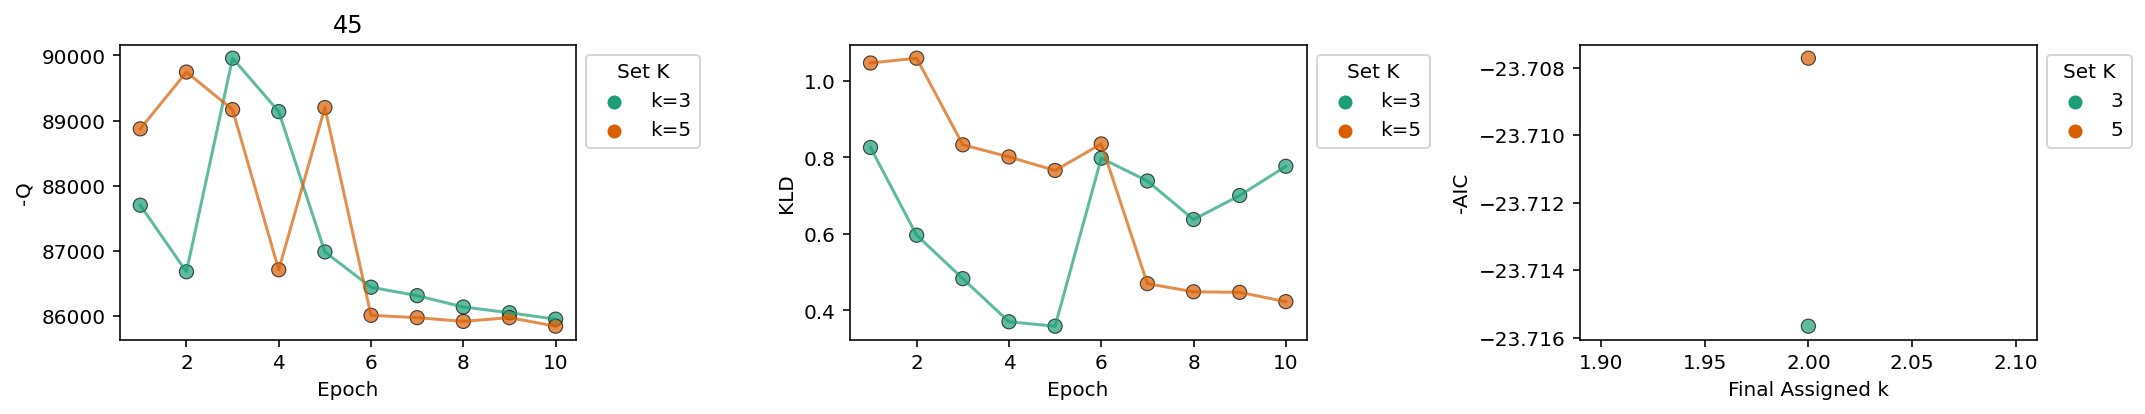

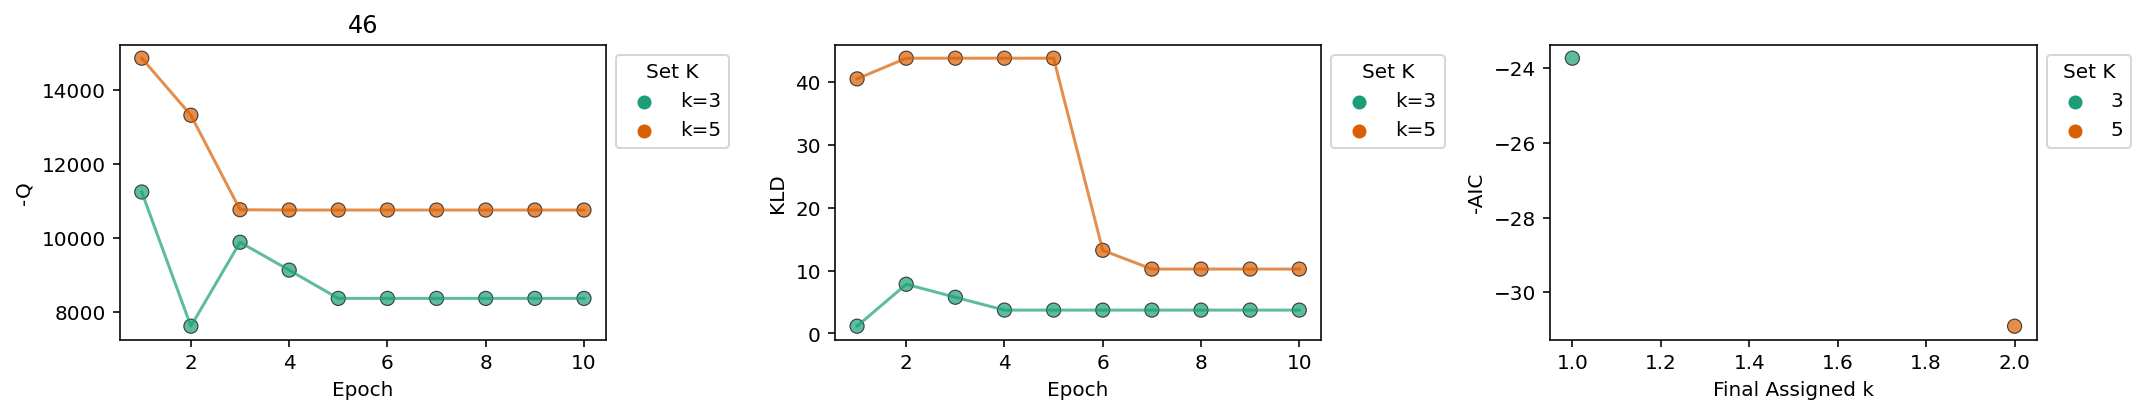

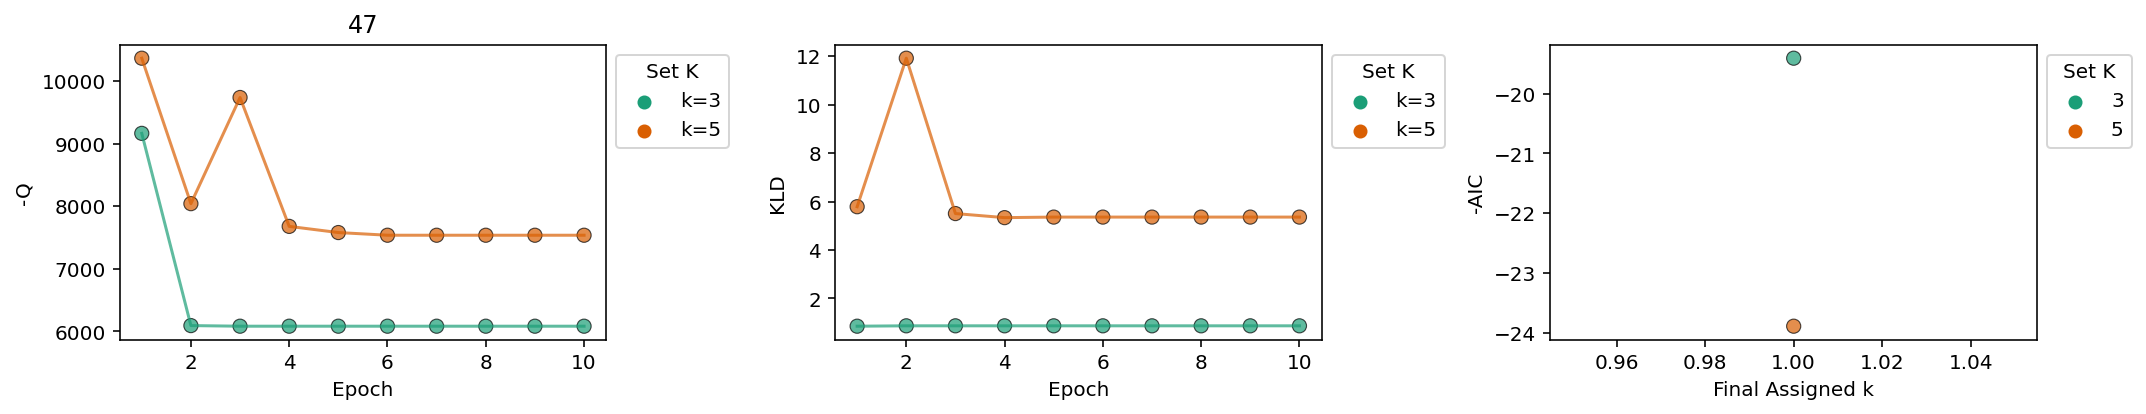

In [144]:
for s in range(0,len(sr),2):
    vis_metrics([sr[s],sr[s+1]],title=rep_conds[s],ks=Ks,figsize=(15,3))

In [145]:
conds_withpops = np.unique(rep_conds[[i for i in range(len(sr)) if len(sr[i]) > 1]])
conds_withpops

array([45, 46])

In [ ]:
#PLOT single/double/triple conds vs no. clusters.



In [146]:
chosen = [1] #Cond 21, K=5
print_summary(sr[1])

--------------------------
Model AIC Score:  -23.707721595193757
Clus 1 with 1100 cells
Clus 4 with 2506 cells
--------------------------


/home/tchari/monod/src/monod/mminference.py:1976: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(
/home/tchari/monod/src/monod/mminference.py:1976: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


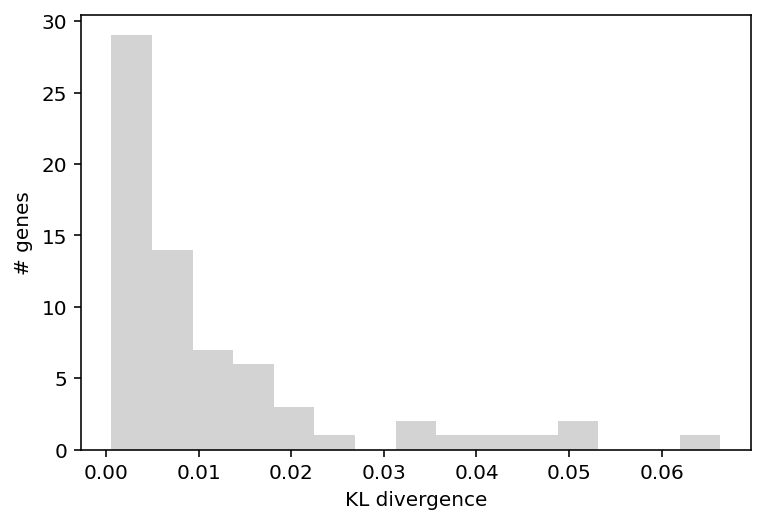

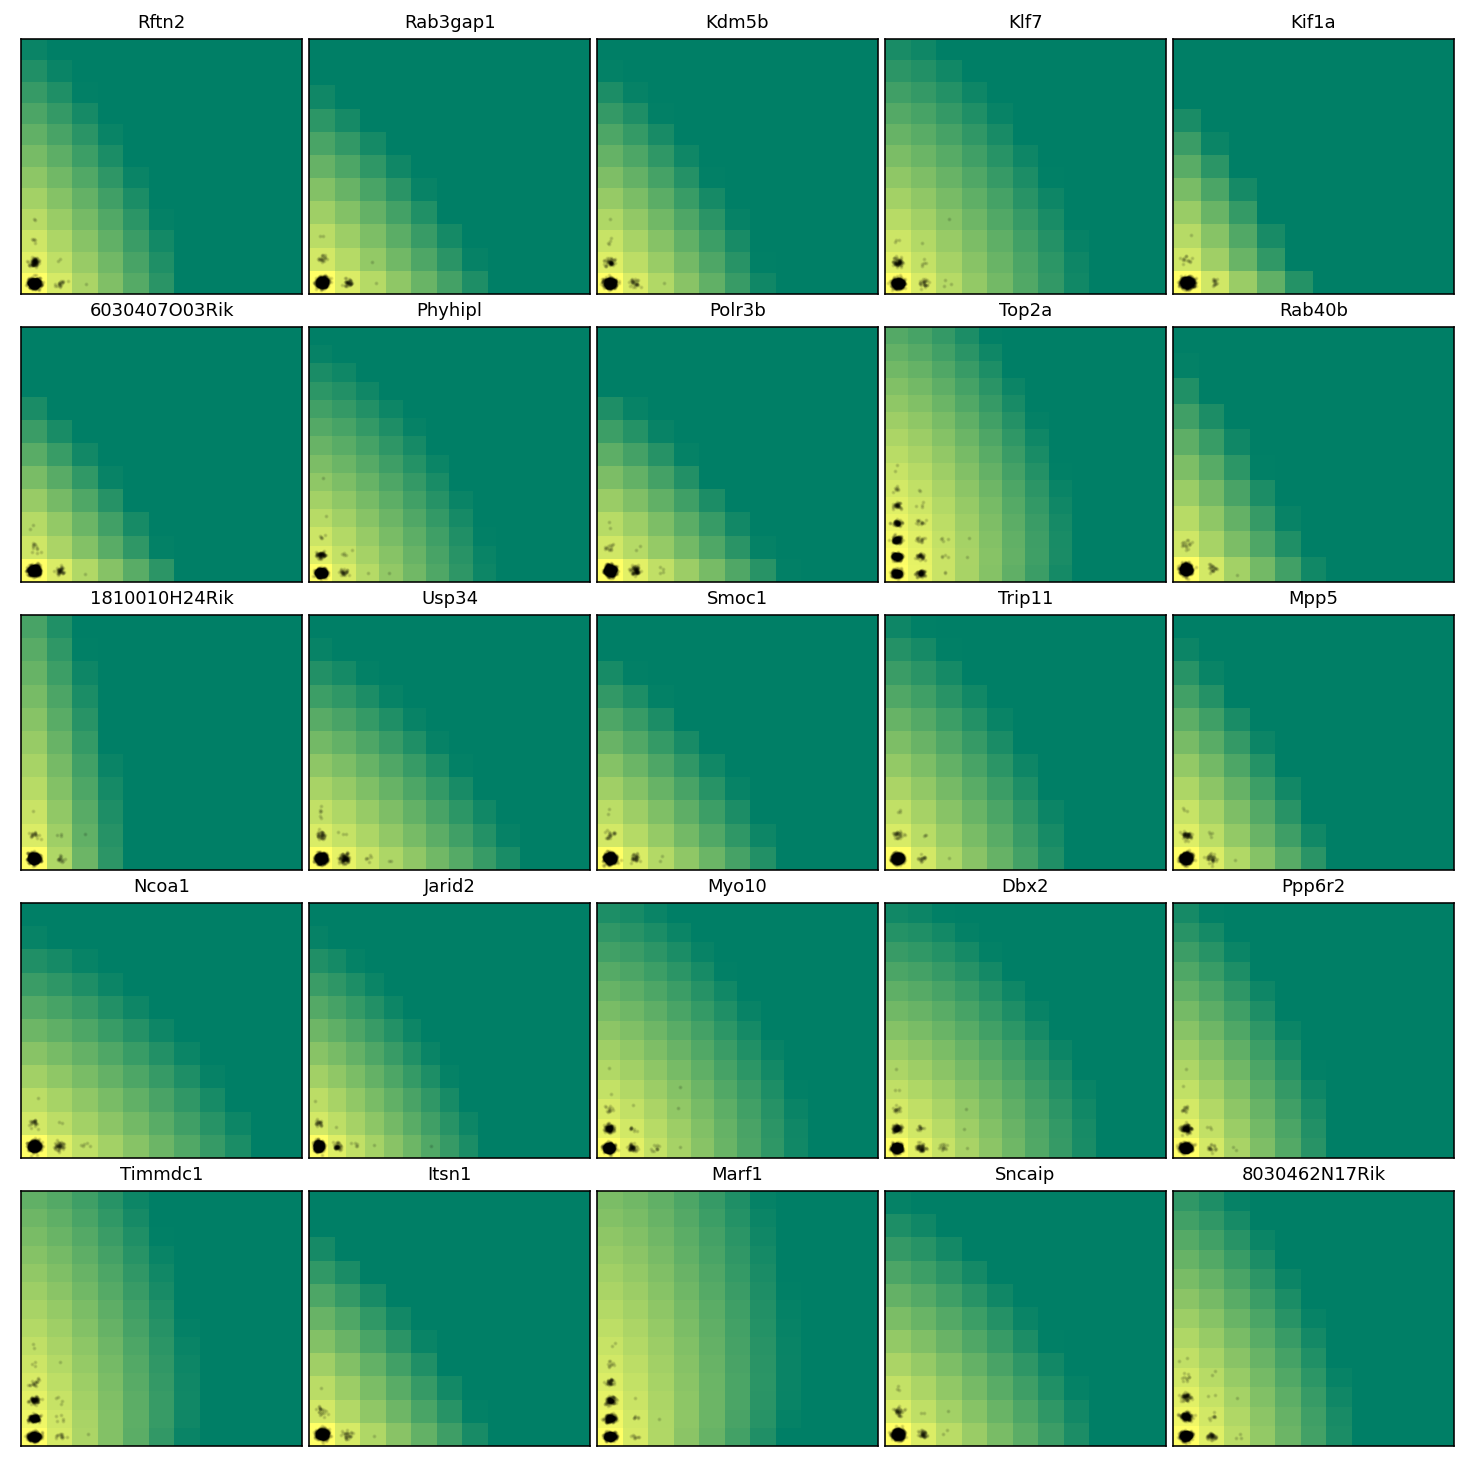

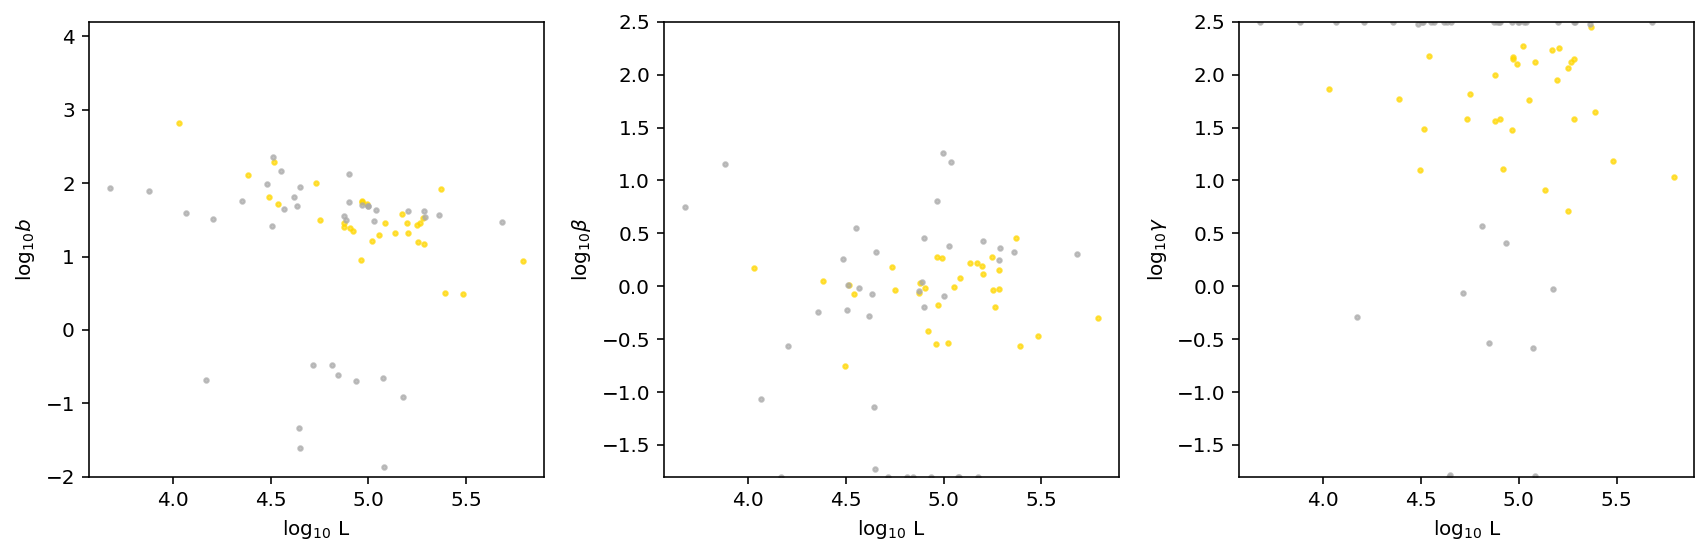

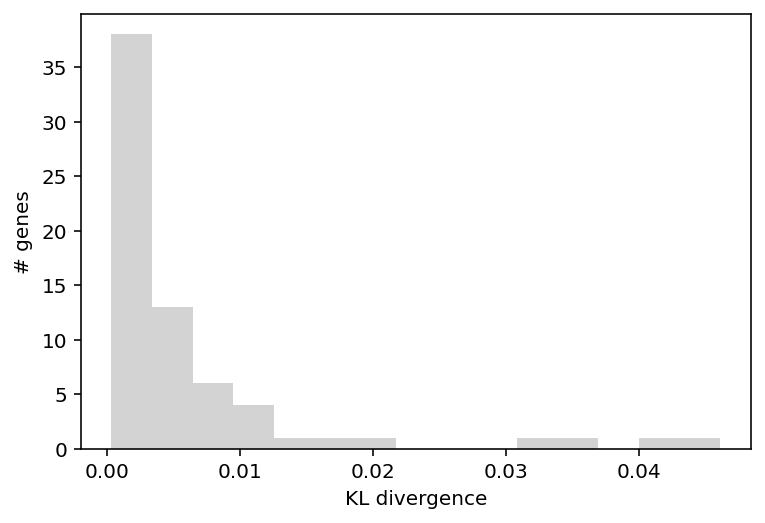

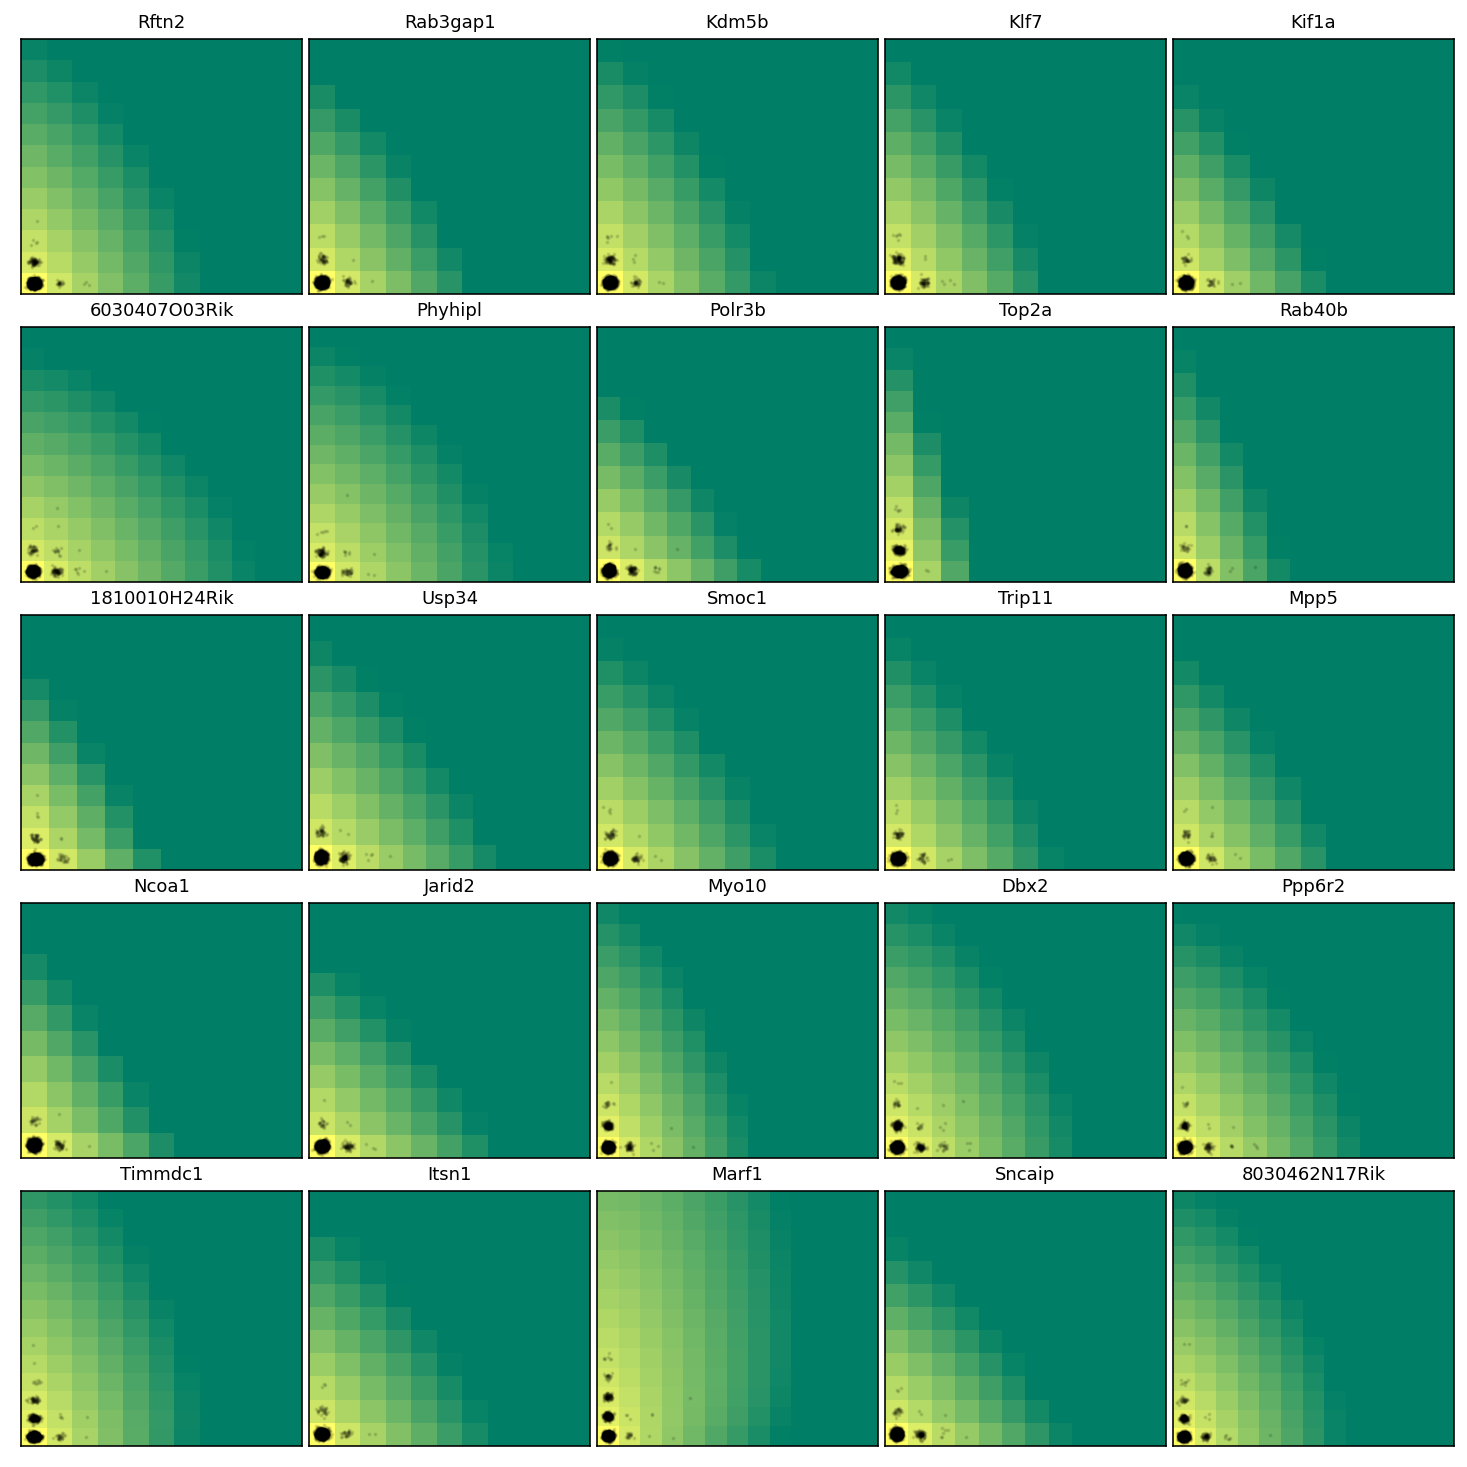

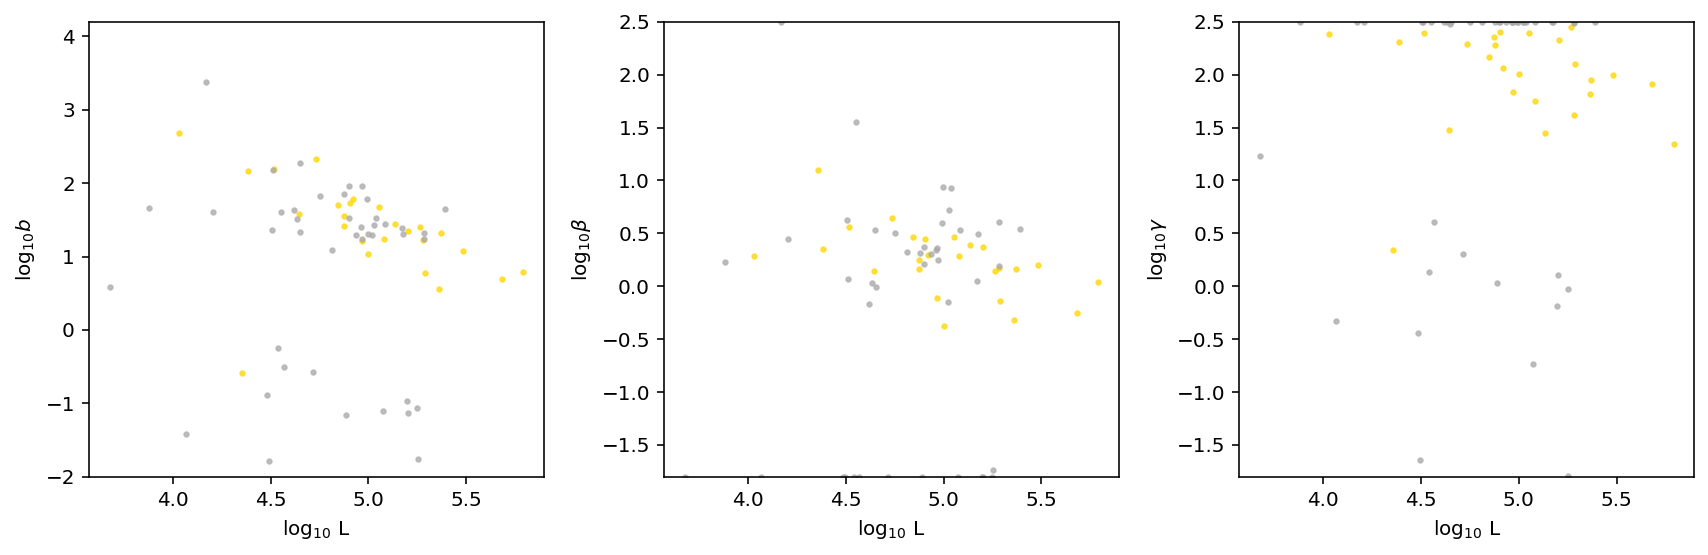

In [151]:
#Reject gene fits and get parameter uncertainty (std error)
for i in range(len(chosen)):
    
    sd2 = sd[chosen[i]][0]
    
    for r in sr[chosen[i]]:

        r.find_sampling_optimum()
 
        fig1,ax1 = plt.subplots(1,1)
        r.plot_KL(ax1)

        r.plot_gene_distributions(sd2,marg='joint') 

        _=r.chisquare_testing(sd2,threshold=1e-3)

        r.chisq_best_param_correction(sd2,Ntries=4,viz=False,threshold=1e-3) 

        r.compute_sigma(sd2,num_cores=30)
        r.plot_param_L_dep(plot_errorbars=False,plot_fit=True)

        monod.analysis.make_batch_analysis_dir([r],dir_string)
        r.update_on_disk()

In [155]:
#Read back in results
sr_cond = [monod.analysis.load_search_results(r[:-4]+'_upd.res') for r in result_strings[1] if 'upd' not in r]
    
sr_cond

In [153]:
result_strings[1]

['./fits/gg_240409_029_meK_gehring_1/meK_gehr_45_k5/Bursty_Poisson_1x1/grid_scan_results_1.res',
 './fits/gg_240409_029_meK_gehring_1/meK_gehr_45_k5/Bursty_Poisson_1x1/grid_scan_results_4.res']

In [ ]:
sd_cond = sd[chosen[i]][0]

### **DE-$\theta$ Analysis of meK-Means Results**

In [162]:
def make_fcs(sr,sd,clus1=0,clus2=1,gf_rej=False,thrpars=2,thrmean=1,outlier_de=True,nuc=False,correct_off=False):
    '''
    Utilize different metrics to find fold-changes (FCs) between cluster parameters

    sr: list of SearchResults objects from meK-Means runs
    sd: SearchData object that corresponds to full, input data
    clus1: cluster 1 (to compare FCS of cluster 1/cluster 2 )
    clus2: cluster 2 (to compare FCS of cluster 1/cluster 2 )
    gf_rej: whether to use boolean list of rejected genes from both clusters
    thrpars: FC threshold value (to call DE-theta genes)
    thrmean: Mean S expression threshold value, for genes to consider
    outlier_de: Use iterative outlier calling procedure to assign DE-theta genes (see Monod https://github.com/pachterlab/monod_examples/blob/main/Monod_demo.ipynb)
    nuc: is this nuclear RNA data
    '''

    all_filt_fcs = pd.DataFrame()
    fcs,types,which_pair,highFC,spliceFC,g_names,out_de = ([] for i in range(7))
    
    ind1 = [i for i in range(len(sr)) if clus1 == sr[i].assigns][0]
    ind2 = [i for i in range(len(sr)) if clus2 == sr[i].assigns][0]

    sr1 = sr[ind1]
    sr2 = sr[ind2]
    if correct_off:
        param_names = sr1.model.get_log_name_str()
        offsets = []
        par_vals = np.copy(sr2.param_estimates)
        for k in range(3):
            m1 = sr1.param_estimates[0,:,k]
            m2 = sr2.param_estimates[0,:,k]
            offset = diffexp_fpi(m1,m2,param_names[k],viz=False)[1]
            par_vals[0,:,k] -= offset

        fc_par = (sr1.param_estimates-par_vals)/np.log10(2)
    else:
        fc_par = (sr1.param_estimates-sr2.param_estimates)/np.log10(2)  #Get FCs between cluster params
        
    print('fc_par.shape: ',fc_par.shape)
    if nuc:
        fc_s_par = np.log2(sd.layers[0][:,sr1.filt].mean(1)/sd.layers[0][:,sr2.filt].mean(1))
    else:
        fc_s_par = np.log2(sd.layers[1][:,sr1.filt].mean(1)/sd.layers[1][:,sr2.filt].mean(1)) #Get spliced FCs
        
    print('fc_s_par.shape: ',fc_s_par.shape)

    if outlier_de:
        dr_analysis = monod.analysis.diffexp_pars(sr1,sr2,viz=True,modeltype='id',use_sigma=True)
        par_bool_de = dr_analysis[1].T

    parnames = ('b','beta','gamma')


  #-----is parameter FC significant -----
    if gf_rej is False:
        gf_rej = [True]*sd.n_genes
    else:
        gf_rej = (~sr1.rejected_genes) & (~sr2.rejected_genes)
        
    for n in range(len(parnames)):
        #Boolean for if large param FC and not rejected gene (with minimum expression)
        if nuc:
            gf_highnoise = (np.abs(fc_par[0,:,n])>thrpars)  \
                & ((sd.layers[0][:,sr1.filt].mean(1)>thrmean) | (sd.layers[0][:,sr2.filt].mean(1)>thrmean)) \
                & gf_rej
        else:
            gf_highnoise = (np.abs(fc_par[0,:,n])>thrpars)  \
                & ((sd.layers[1][:,sr1.filt].mean(1)>thrmean) | (sd.layers[1][:,sr2.filt].mean(1)>thrmean)) \
                & gf_rej

        #Boolean for FC (above) but no FC detected at S-level
        gf_highnoise_meanS = gf_highnoise & (np.abs(fc_s_par)<1) & gf_rej

        #Boolean for FC (above)
        gf_onlyhigh = gf_highnoise & gf_rej

        #For dataframe
        fcs += list(fc_par[0,gf_rej,n])
        g_names += list(sr1.gene_names[gf_rej])
        which_pair += [[sr1.assigns,sr2.assigns]]*np.sum(gf_rej)
        highFC += list(gf_onlyhigh[gf_rej])
        spliceFC += list(gf_highnoise_meanS[gf_rej])
        types += [parnames[n]]*np.sum(gf_rej)
        if outlier_de:
            out_de += list(par_bool_de[gf_rej,n])

    if outlier_de:
        all_filt_fcs['deTheta_outlier'] = out_de

    all_filt_fcs['log2FC'] = fcs
    all_filt_fcs['gene'] = g_names
    all_filt_fcs['cluster_pair'] = which_pair
    all_filt_fcs['deTheta_FC'] = highFC
    all_filt_fcs['deTheta_noDeMuS'] = spliceFC
    all_filt_fcs['param'] = types

    return all_filt_fcs


In [163]:
#Get params for each gene, which cluster it marks, and whether it's DE in any param
def get_gene_DE(all_filt_fcs):
    bs = all_filt_fcs[all_filt_fcs.param.isin(['b'])].log2FC
    betas = all_filt_fcs[all_filt_fcs.param.isin(['beta'])].log2FC
    gammas = all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].log2FC
    highFCs = np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].deTheta_FC)
    noSpliceFCs = np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].deTheta_noDeMuS) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].deTheta_noDeMuS) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].deTheta_noDeMuS)

    names = all_filt_fcs[all_filt_fcs.param.isin(['b'])].gene

    dom = []
    for i in range(len(noSpliceFCs)):
        fc_b = list(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].log2FC)[0]
        fc_beta = list(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].log2FC)[0]
        fc_gamma = list(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].log2FC)[0]

        sig_b = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].deTheta_noDeMuS))[0]
        sig_beta = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].deTheta_noDeMuS))[0]

        sig_gamma = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].deTheta_noDeMuS))[0]


        pairs = list(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].cluster_pair)[0]

# ----- Cell type 'marker' means increase in burst freq,burst,or splicing, or decrease in deg (increased 'stability') ----

        #Increase in burst freq (not outweighted by burst size)
        if (-1*fc_beta > 0 and sig_beta and -1*fc_gamma > 0 and sig_gamma) :
            if (np.abs(fc_b) < np.abs(fc_beta)):
                dom += [pairs[0]]
            elif (fc_b > 0 and sig_b):
                dom += [pairs[0]]
            elif (fc_b < 0 and sig_b):
                dom += [pairs[1]]
            else:
                dom += ['None']
        elif (fc_beta > 0 and sig_beta and fc_gamma > 0 and sig_gamma) :
            if (np.abs(fc_b) < np.abs(fc_beta)):
                dom += [pairs[1]]
            elif (fc_b > 0 and sig_b):
                dom += ['None'] #don't know
            elif (fc_b < 0 and sig_b):
                dom += [pairs[1]]
            else:
                dom += ['None']
        elif sig_b:
            if np.abs(fc_b) > np.abs(fc_beta) and np.abs(fc_b) > np.abs(fc_gamma):
                if fc_b > 0:
                    dom += [pairs[0]]
                else:
                    dom += [pairs[1]]            
            elif np.abs(fc_b) < np.abs(fc_beta):
                if fc_beta > 0:
                    dom += [pairs[0]]
                elif fc_beta < 0:
                    dom += [pairs[1]]
            elif np.abs(fc_b) < np.abs(fc_gamma):
                if fc_gamma < 0:
                    dom += [pairs[0]]
                elif fc_gamma > 0:
                    dom += [pairs[1]]
            else:
                dom += ['None']       
        elif (fc_beta > 0 and sig_beta):
            dom += [pairs[0]]
        elif (fc_gamma > 0 and sig_gamma): #individual FCs
            dom += [pairs[1]]
        elif  (fc_beta < 0 and sig_beta):
            dom += [pairs[1]]
        elif (fc_gamma < 0 and sig_gamma):
            dom += [pairs[0]]
        else:
            dom += ['None']


    return bs,-1*betas,-1*gammas,dom,highFCs,noSpliceFCs,names #-1 for plotting purposes

In [164]:
#Plot FCs of parameters between two clusters

def plot_de(outs,names_plot,mark_plot,xpos,ypos,arrow,assign_colors,figsize=(10,4),betag=False,xlims=[-10,10],fname=None):
    fig,ax = plt.subplots(1,2,figsize=figsize)

    name_inds = [list(outs[6]).index(i) for i in names_plot]

    labs = np.array(outs[3])
    g=sns.scatterplot(x=list(outs[0][labs =='None']),y=list(outs[1][labs=='None']),
                      hue=list(pd.Categorical(outs[3])[labs=='None']),
                      palette=assign_colors,ax=ax[0],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

    sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==False)]),
                    y=list(outs[1][(labs!='None') &  (outs[5]==False)]),
                    hue=list(pd.Categorical(outs[3])[(labs!='None') &  (outs[5]==False)]),
                      palette=assign_colors,ax=ax[0],marker='o',alpha=0.6,s=100,edgecolor='black')

    sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==True)]),
                    y=list(outs[1][(labs!='None')  &  (outs[5]==True)]),
                    hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                      palette=assign_colors,ax=ax[0],marker='X',alpha=0.8,s=120,edgecolor='black')

    #Annotate genes
    for n in range(len(names_plot)):
        x=list(outs[0])[name_inds[n]]
        y=list(outs[1])[name_inds[n]]
        h=[pd.Categorical(outs[3])[name_inds[n]]]
        if_x=list(outs[5])[name_inds[n]]
        
        if if_x:
            shape = 'X'
        else:
            shape = 'o'
            
        if arrow[n]:
            #Replot, so annotated points show up on top
            sns.scatterplot(x=x,
                    y=y,
                    hue=h,
                      palette=assign_colors,ax=ax[0],marker=shape,alpha=0.8,s=120,edgecolor='black',
                           legend=False)
            
            ax[0].annotate(names_plot[n], (x, y), fontsize=14,
                           xytext=(x+xpos[n],y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                       arrowprops = dict(facecolor=assign_colors[mark_plot[n]],  
                                         arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",lw=0.4))
        else:
            #Replot, so annotated points show up on top
            sns.scatterplot(x=x,
                    y=y,
                    hue=h,
                      palette=assign_colors,ax=ax[0],marker=shape,alpha=0.8,s=120,edgecolor='black',
                           legend=False)
            
            ax[0].annotate(names_plot[n], (x, y),fontsize=14,
                           xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")

    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

    xl =np.asarray([xlims[0],xlims[1]])
    xlx = [xl[0],xl[1]]
    xly = [xl[0],xl[1]]
    ax[0].set_xlim(xlx)
    ax[0].set_ylim(xly)

    ax[0].plot(xl,-xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

    ax[0].set_xlabel(r'$\log_{2}$FC $b$ ',fontsize=14)
    ax[0].set_ylabel(r'$-\log_{2}$FC $\beta$ ',fontsize=14)
    
    ax[0].tick_params(axis='both', which='major', labelsize=14,)




    if betag == False:
        labs = np.array(outs[3])
        g=sns.scatterplot(x=list(outs[0][labs =='None']),y=list(outs[2][labs=='None']),
                          hue=list(pd.Categorical(outs[3])[labs=='None']),
                          palette=assign_colors,ax=ax[1],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

        sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==False)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==False)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==False)]),
                          palette=assign_colors,ax=ax[1],marker='o',alpha=0.6
                        ,s=100,edgecolor='black')

        
        sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==True)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==True)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                          palette=assign_colors,ax=ax[1],marker='X',
                        alpha=0.8,s=120,edgecolor='black')
        #Annotate genes
        for n in range(len(names_plot)):
            x=list(outs[0])[name_inds[n]]
            y=list(outs[2])[name_inds[n]]
            h=[pd.Categorical(outs[3])[name_inds[n]]]
            if_x=list(outs[5])[name_inds[n]]

            if if_x:
                shape = 'X'
            else:
                shape = 'o'

            if arrow[n]:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=100,edgecolor='black',
                               legend=False)
            
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                           arrowprops = dict(facecolor=assign_colors[mark_plot[n]],  
                                             arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",
                                             lw=0.4,))
            else:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)
            
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")


        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

        xl =np.asarray([xlims[0],xlims[1]])
        xlx = [xl[0],xl[1]]
        xly = [xl[0],xl[1]]
        ax[1].set_xlim(xlx)
        ax[1].set_ylim(xly)

        ax[1].plot(xl,-xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

        ax[1].set_xlabel(r'$\log_{2}$FC $b$ ',fontsize=14)
        ax[1].set_ylabel(r'$-\log_{2}$FC $\gamma$ ',fontsize=14)
        
        ax[1].tick_params(axis='both', which='major', labelsize=14,)
    else:
        labs = np.array(outs[3])
        g=sns.scatterplot(x=list(outs[1][labs =='None']),y=list(outs[2][labs=='None']),
                          hue=list(pd.Categorical(outs[3])[labs=='None']),
                          palette=assign_colors,ax=ax[1],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

        sns.scatterplot(x=list(outs[1][(labs!='None')  &  (outs[5]==False)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==False)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==False)]),
                          palette=assign_colors,ax=ax[1],marker='o',alpha=0.6
                        ,s=100,edgecolor='black')

        
        sns.scatterplot(x=list(outs[1][(labs!='None')  &  (outs[5]==True)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==True)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                          palette=assign_colors,ax=ax[1],marker='X',
                        alpha=0.8,s=120,edgecolor='black')
        #Annotate genes
        for n in range(len(names_plot)):
            x=list(outs[1])[name_inds[n]]
            y=list(outs[2])[name_inds[n]]
            h=[pd.Categorical(outs[3])[name_inds[n]]]
            if_x=list(outs[5])[name_inds[n]]

            if if_x:
                shape = 'X'
            else:
                shape = 'o'

                
            if arrow[n]:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)
                
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                           arrowprops = dict(facecolor=assign_colors[mark_plot[n]],  
                                             arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",
                                             lw=0.4,))
            else:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)
                
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")



        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

        xl =np.asarray([xlims[0],xlims[1]])
        xlx = [xl[0],xl[1]]
        xly = [xl[0],xl[1]]
        ax[1].set_xlim(xlx)
        ax[1].set_ylim(xly)

        ax[1].plot(xl,xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

        ax[1].set_xlabel(r'$-\log_{2}$FC $\beta$ ',fontsize=14)
        ax[1].set_ylabel(r'$-\log_{2}$FC $\gamma$ ',fontsize=14)
        
        ax[1].tick_params(axis='both', which='major', labelsize=14,)
        

    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)



fc_par.shape:  (1, 68, 3)
fc_s_par.shape:  (68,)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


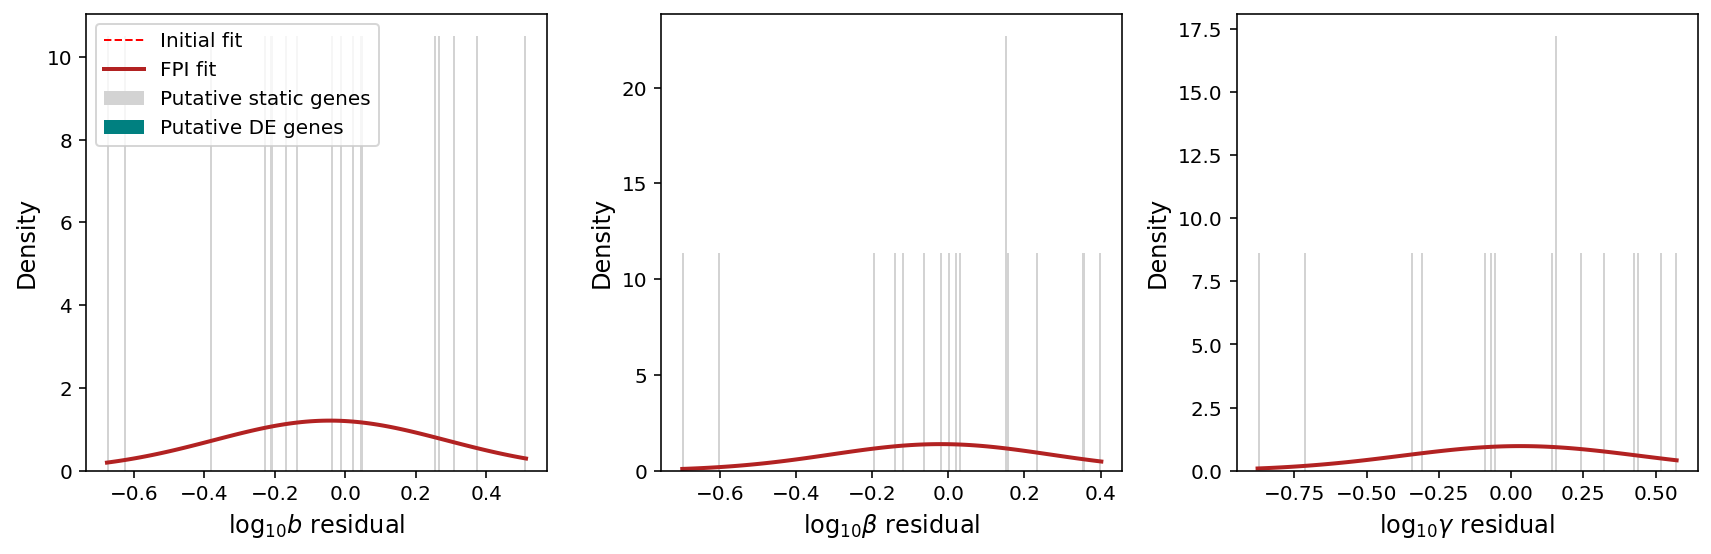

In [172]:
#Compare  0 vs 1 (E13 vs E11)
all_filt_fcs = make_fcs(sr_cond,sd_cond,clus1=1,clus2=4,
                gf_rej=True,thrpars=2,thrmean=0.1,outlier_de=True,nuc=False,correct_off=True)

In [173]:
all_filt_fcs[all_filt_fcs['deTheta_FC'].isin([True])]

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
7,False,-2.119796,8030462N17Rik,"[1, 4]",True,False,b
23,False,-2.123330,8030462N17Rik,"[1, 4]",True,False,beta
38,False,-2.065791,Marf1,"[1, 4]",True,False,gamma
39,False,-2.891728,8030462N17Rik,"[1, 4]",True,False,gamma
41,False,-2.711463,Nusap1,"[1, 4]",True,False,gamma
43,False,-2.444974,Ncoa3,"[1, 4]",True,False,gamma


In [175]:
#Fisher information...
hess = [sr_cond[0].par_fun_hess(x)
        for x in zip(range(sr_cond[0].n_genes), [sd_cond] * sr_cond[0].n_genes)
        ]

In [183]:
hess[0]

array([[ 0.52378629, -0.12486514, -0.40434482],
       [-0.12486514,  0.14306679, -0.00370037],
       [-0.40434482, -0.00370037,  0.41331748]])

In [160]:
# [i for i in sd_cond.gene_names if i in lit_genes]